In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64}, nrows=1000000)
print(data.shape)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

(1000000, 2)
cuda


In [3]:
X_train = torch.tensor(data['acoustic_data'][:800000], dtype=torch.float32)
y_train = torch.tensor(data['time_to_failure'][:800000], dtype=torch.float32)
X_val = torch.tensor(np.array(data['acoustic_data'][800000:]), dtype=torch.float32)
y_val = torch.tensor(np.array(data['time_to_failure'][800000:]), dtype=torch.float32)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

torch.Size([800000]) torch.Size([800000])
torch.Size([200000]) torch.Size([200000])


In [4]:
'''from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
train_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)'''
print(max(X_train), min(X_train))
print(max(y_train), min(y_train))

tensor(104.) tensor(-98.)
tensor(1.4691) tensor(1.4436)


In [5]:
print(torch.mean(X_train), torch.mean(y_train))

tensor(5.0159) tensor(1.4567)


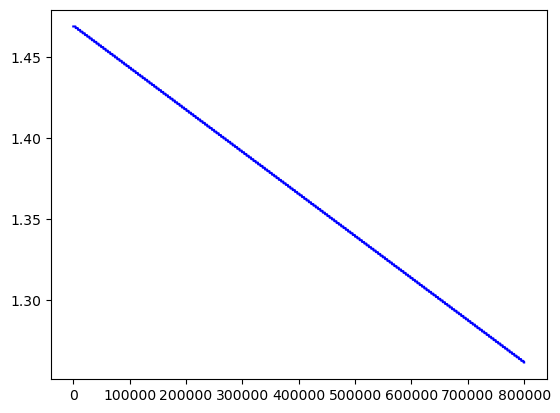

In [4]:
#plt.plot(list(range(len(X_train))), X_train.numpy(), c="r")
plt.plot(y_train.numpy(), c="b")
plt.show()

In [11]:
class RNNModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=16, layer_dim=1, output_dim=1, dropout_prob=0.5):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        for p in self.rnn.parameters():
            nn.init.normal_(p, mean=0.0, std=0.001)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden_prev):
        out, hidden_prev = self.rnn(x, hidden_prev)        
        out = self.fc(out)
        return out, hidden_prev


In [12]:
model = RNNModel()
#test model input and output
o, h = model(torch.tensor([[0.1]]), torch.randn((1, 16)))
print(o)
print(h.shape)

tensor([[0.1820]], grad_fn=<AddmmBackward0>)
torch.Size([1, 16])


d:\ProgramData\Anaconda3\envs\mydl\Lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [18]:
num_time_steps = 50
input_size = 1
hidden_size = 16
output_size = 1
lr = 0.01
print_iter = 2000
val_iter = 10000
val_length = 5000
train_losses = []
val_losses = []

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr)
hidden_prev = torch.zeros((1, hidden_size), dtype=torch.float32)

for iter in range(len(X_train)):
    loss_sum = 0.0
    output, hidden_prev = model(X_train[iter].reshape((1,1)), hidden_prev)
    hidden_prev = hidden_prev.detach()
    loss = criterion(output, y_train[iter].reshape((1,1)))
    loss_sum += loss.item()
    model.zero_grad()
    loss.backward()
    optimizer.step()

    '''if iter % print_iter == 0:
        print("Iteration: {} loss {}".format(iter, loss_sum / print_iter))
        loss_sum = 0.0'''
    if iter % val_iter == 0 and iter != 0:
        print("Iteration: {} loss {}".format(iter, loss_sum / val_iter))
        train_losses.append(loss_sum / val_iter)
        loss_sum = 0.0
        with torch.no_grad():
            val_hidden_prev = torch.zeros((1, hidden_size), dtype=torch.float32)
            model.eval()
            val_loss_sum = 0.0
            for vi in range(val_length):
                output, val_hidden_prev = model(X_test[vi].reshape((1,1)), val_hidden_prev)
                loss = criterion(output, y_test[vi].reshape((1,1)))
                val_loss_sum += loss.item()
            print("Validation loss {}".format(val_loss_sum / val_length))
            val_losses.append(val_loss_sum / val_length)
        


Iteration: 10000 loss 4.764061145579035e-13
Validation loss 0.0005805691079323878
Iteration: 20000 loss 1.7195134205394424e-16
Validation loss 0.0008650640143256169
Iteration: 30000 loss 1.7149206541944296e-08
Validation loss 0.0012101416094461455
Iteration: 40000 loss 1.2789769243681803e-17
Validation loss 0.00028277920166729016
Iteration: 50000 loss 1.1510792319313622e-16
Validation loss 0.0001806103797367541
Iteration: 60000 loss 5.684341886080802e-18
Validation loss 0.00012654217352246633
Iteration: 70000 loss 1.7408297026122454e-15
Validation loss 7.626921937408042e-05
Iteration: 80000 loss 2.0463630789890885e-16
Validation loss 4.5362099456542635e-05
Iteration: 90000 loss 3.173655131831765e-08
Validation loss 0.00013590838706295473


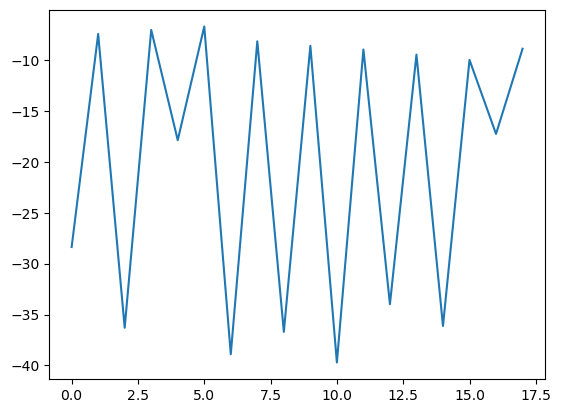

In [19]:

plt.plot(list(range(len(train_losses))), np.log(train_losses))
plt.show()

[]


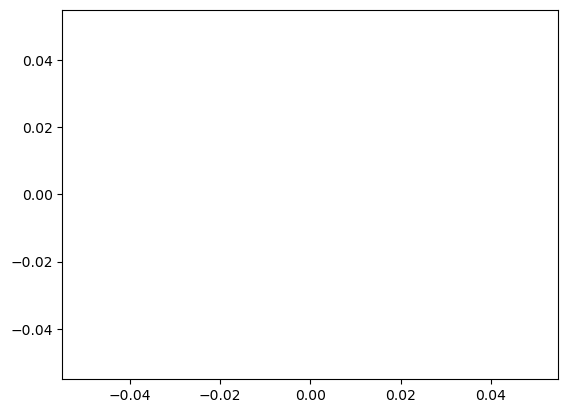

In [21]:
print(val_losses)
plt.plot(list(range(len(val_losses))), val_losses)
plt.show()

In [26]:
yhat_val = []
with torch.no_grad():
    val_hidden_prev = torch.zeros((1, hidden_size), dtype=torch.float32)
    model.eval()
    for vi in range(val_length):
        output, val_hidden_prev = model(X_test[vi].reshape((1,1)), val_hidden_prev)
        yhat_val.append(output.numpy()[0][0])
print(yhat_val)
print(len(yhat_val))

[1.6792552, 1.4435679, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.443568, 1.44356

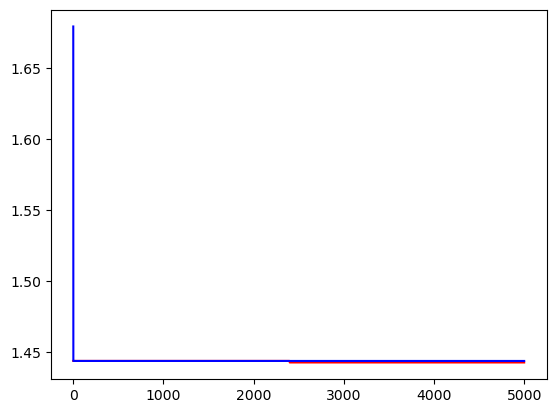

In [27]:
plt.plot(list(range(val_length)), y_test[:val_length], c="r")
plt.plot(list(range(val_length)), yhat_val, c="b")
plt.show()

In [28]:
print(y_test[:val_length])

tensor([1.4436, 1.4436, 1.4436,  ..., 1.4425, 1.4425, 1.4425])
